# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran

## Stage 2: Advanced Embedding Models Training and Analysis

### Data Preparation for Embeddings

In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.getcwd()

# Change current working directory to where the notebook resides
os.chdir(notebook_dir)

# List of required libraries
required_libraries = [
    'gensim',
    'pandas',
    'scipy==1.12'
]

# Check if each library is installed, if not, install it
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        print(f"Installing {lib}...")
        !"{sys.executable}" -m pip install {lib}

Installing scipy==1.12...


In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Jupyter config
%config InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# Get the preprocessed data from stage 1
google_patent_original = pd.read_csv("Data/google_patent_en_preprocessed.csv")
media_original = pd.read_csv("Data/ct_media_preprocessed.csv")
media_evaluation_original = pd.read_csv("Data/ct_evaluation_preprocessed.csv")

In [4]:
# This function will provide with more useful information:
def analyze_column(df, has_list=False):
    info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Number of Entries': df.count(),
        'Missing/None Count': df.isna().sum(),
        'Uniqueness': df.nunique()
    })
    
    return info

print("Google Patent Dataset:")
google_patent_original['publication_date'] = pd.to_datetime(google_patent_original['publication_date'])
google_patent_original.head()
analyze_column(google_patent_original)
print("\nNumber of duplicate rows:", media_original.duplicated().sum())

Google Patent Dataset:


,publication_number,country_code,publication_date,title_localized_text,abstract_localized_text,title_tokens,abstract_tokens,title_token_count,abstract_token_count
0,US-2022239235-A1,US,2022-07-28,adaptable dcac inverter drive system and opera...,disclosed is an adaptable dcac inverter system...,"['adapt', 'dcac', 'invert', 'drive', 'system',...","['disclos', 'adapt', 'dcac', 'invert', 'system...",7,64
1,US-2022239251-A1,US,2022-07-28,system for providing the energy from a single ...,in accordance with an example embodiment a sol...,"['system', 'provid', 'energi', 'singl', 'conti...","['accord', 'exampl', 'embodi', 'solar', 'energ...",18,92
2,US-11396827-B2,US,2022-07-26,control method for optimizing solartopower eff...,a control method for optimizing a solartopower...,"['control', 'method', 'optim', 'solartopow', '...","['control', 'method', 'optim', 'solartopow', '...",15,149
3,CN-114772674-A,CN,2022-07-22,lowcarbon running saline wastewater treatment ...,the invention discloses a system and a method ...,"['lowcarbon', 'run', 'salin', 'wastewat', 'tre...","['invent', 'disclos', 'system', 'method', 'tre...",15,226
4,CN-217026795-U,CN,2022-07-22,water ecological remediation device convenient...,the utility model discloses a water ecological...,"['water', 'ecolog', 'remedi', 'devic', 'conven...","['util', 'model', 'disclos', 'water', 'ecolog'...",7,252


,Data Type,Number of Entries,Missing/None Count,Uniqueness
publication_number,object,13412,0,13351
country_code,object,13412,0,29
publication_date,datetime64[ns],13412,0,158
title_localized_text,object,13412,0,12441
abstract_localized_text,object,13412,0,13250
title_tokens,object,13412,0,12424
abstract_tokens,object,13412,0,13235
title_token_count,int64,13412,0,30
abstract_token_count,int64,13412,0,282



Number of duplicate rows: 0


In [5]:
print("Media Dataset:")
media_original['date'] = pd.to_datetime(media_original['date'])
media_original.head()
analyze_column(media_original)
print("\nNumber of duplicate rows:", media_original.duplicated().sum())

Media Dataset:


,title,date,content,domain,title_tokens,content_tokens,title_token_count,content_token_count
0,qatar to slash emissions as lng expansion adva...,2021-01-13,qatar petroleum qp is targeting aggressive cut...,energyintel,"['qatar', 'slash', 'emiss', 'lng', 'expans', '...","['qatar', 'petroleum', 'qp', 'target', 'aggres...",8,442
1,india launches its first 700 mw phwr,2021-01-15,nuclear power corp of india ltd npcil synchro...,energyintel,"['india', 'launch', 'first', '700', 'mw', 'phwr']","['nuclear', 'power', 'corp', 'india', 'ltd', '...",7,538
2,new chapter for uschina energy trade,2021-01-20,new us president joe biden took office this we...,energyintel,"['new', 'chapter', 'uschina', 'energi', 'trade']","['new', 'presid', 'joe', 'biden', 'took', 'off...",6,706
3,japan slow restarts cast doubt on 2030 energy ...,2021-01-22,the slow pace of japanese reactor restarts con...,energyintel,"['japan', 'slow', 'restart', 'cast', 'doubt', ...","['slow', 'pace', 'japanes', 'reactor', 'restar...",9,687
4,nyc pension funds to divest fossil fuel shares,2021-01-25,two of new york citys largest pension funds sa...,energyintel,"['nyc', 'pension', 'fund', 'divest', 'fossil',...","['two', 'new', 'york', 'citi', 'largest', 'pen...",8,394


,Data Type,Number of Entries,Missing/None Count,Uniqueness
title,object,9593,0,9565
date,datetime64[ns],9593,0,967
content,object,9593,0,9588
domain,object,9593,0,19
title_tokens,object,9593,0,9563
content_tokens,object,9593,0,9587
title_token_count,int64,9593,0,25
content_token_count,int64,9593,0,1782



Number of duplicate rows: 0


In [6]:
print("Media Evaluation Dataset:")
media_evaluation_original.head()
analyze_column(media_evaluation_original)
print("\nNumber of duplicate rows:", media_evaluation_original.duplicated().sum())

Media Evaluation Dataset:


,example_id,question_id,question,relevant_chunk,domain,question_tokens,relevant_chunk_tokens,question_token_count,relevant_chunk_token_count
0,1,1,what is the innovation behind leclanches new m...,leclanche said it has developed an environment...,sgvoice.net,"['innov', 'behind', 'leclanch', 'new', 'method...","['leclanch', 'said', 'develop', 'environment',...",12,36
1,2,2,what is the eus green deal industrial plan,the green deal industrial plan is a bid by the...,sgvoice.net,"['eu', 'green', 'deal', 'industri', 'plan']","['green', 'deal', 'industri', 'plan', 'bid', '...",8,47
2,3,2,what is the eus green deal industrial plan,the european counterpart to the us inflation r...,pv-magazine.com,"['eu', 'green', 'deal', 'industri', 'plan']","['european', 'counterpart', 'inflat', 'reduct'...",8,35
3,4,3,what are the four focus areas of the eus green...,the new plan is fundamentally focused on four ...,sgvoice.net,"['four', 'focu', 'area', 'eu', 'green', 'deal'...","['new', 'plan', 'fundament', 'focus', 'four', ...",13,42
4,5,4,when did the cooperation between gm and honda ...,what caught our eye was a new hookup between g...,cleantechnica.com,"['cooper', 'gm', 'honda', 'fuel', 'cell', 'veh...","['caught', 'eye', 'new', 'hookup', 'gm', 'hond...",13,60


,Data Type,Number of Entries,Missing/None Count,Uniqueness
example_id,int64,23,0,23
question_id,int64,23,0,21
question,object,23,0,21
relevant_chunk,object,23,0,23
domain,object,23,0,6
question_tokens,object,23,0,21
relevant_chunk_tokens,object,23,0,23
question_token_count,int64,23,0,12
relevant_chunk_token_count,int64,23,0,18



Number of duplicate rows: 0


In [7]:
# Get all the rows with an unique country_code
class_counts = google_patent_original['country_code'].value_counts()
single_instances = class_counts[class_counts == 1].index.tolist()

# Update country_code for single-instance classes
google_patent_original.loc[google_patent_original['country_code'].isin(single_instances), 'country_code'] = 'OT'  # OT = Other

In [8]:
# Split patent data into training and validation sets, country code is been splitted equal
patent_train, patent_val = train_test_split(google_patent_original, test_size=0.2, stratify=google_patent_original['country_code'], random_state=42)

# Split media data into training and validation sets, domain is been splitted equal
media_train, media_val = train_test_split(media_original, test_size=0.2, stratify=media_original['domain'], random_state=42)

### Word Embedding Training

#### Word2Vec

In [9]:
def clean_tokenized_data(data):
    return [ast.literal_eval(sentence) for sentence in data]

# Function to train Word2Vec model
def train_word2vec_model(data, vector_size=100, window=5, min_count=1, epochs=10):
    model = Word2Vec(sentences=data, vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
    return model

# Define parameters for training and evaluation
parameters = {
    'vector_size': [100, 200],
    'window': [5, 10],
    'min_count': [1, 5],
    'epochs': [10, 20]
}

def hypertrain(model_basename, train_data):
    models: dict[str, Word2Vec] = {}
    for vector_size in parameters['vector_size']:
        for window in parameters['window']:
            for min_count in parameters['min_count']:
                for epochs in parameters['epochs']:
                    # Train Word2Vec model
                    model_name = f'{model_basename}_{vector_size}_{window}_{min_count}_{epochs}'
                    print(f'Training Word2Vec model {model_name} ...')
                    model = train_word2vec_model(train_data, vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
                    models[model_name] = model
    return models

##### Google patent

###### Title

In [10]:
# Define train and validation data
train_data = clean_tokenized_data(patent_train['title_tokens'].tolist())
validation_data = patent_val['title_tokens']

# Train and validate Word2Vec models
patent_word_title_models = hypertrain("patent_title", train_data)

Training Word2Vec model patent_title_100_5_1_10 ...
Training Word2Vec model patent_title_100_5_1_20 ...
Training Word2Vec model patent_title_100_5_5_10 ...
Training Word2Vec model patent_title_100_5_5_20 ...
Training Word2Vec model patent_title_100_10_1_10 ...
Training Word2Vec model patent_title_100_10_1_20 ...
Training Word2Vec model patent_title_100_10_5_10 ...
Training Word2Vec model patent_title_100_10_5_20 ...
Training Word2Vec model patent_title_200_5_1_10 ...
Training Word2Vec model patent_title_200_5_1_20 ...
Training Word2Vec model patent_title_200_5_5_10 ...
Training Word2Vec model patent_title_200_5_5_20 ...
Training Word2Vec model patent_title_200_10_1_10 ...
Training Word2Vec model patent_title_200_10_1_20 ...
Training Word2Vec model patent_title_200_10_5_10 ...
Training Word2Vec model patent_title_200_10_5_20 ...


###### Text

In [12]:
# Define train and validation data
train_data = clean_tokenized_data(patent_train['abstract_tokens'].tolist())
validation_data = patent_val['abstract_tokens']

# Train and validate Word2Vec models
patent_word_abstract_models = hypertrain("patent_abstract", train_data)

Training Word2Vec model patent_abstract_100_5_1_10 ...
Training Word2Vec model patent_abstract_100_5_1_20 ...
Training Word2Vec model patent_abstract_100_5_5_10 ...
Training Word2Vec model patent_abstract_100_5_5_20 ...
Training Word2Vec model patent_abstract_100_10_1_10 ...
Training Word2Vec model patent_abstract_100_10_1_20 ...
Training Word2Vec model patent_abstract_100_10_5_10 ...
Training Word2Vec model patent_abstract_100_10_5_20 ...
Training Word2Vec model patent_abstract_200_5_1_10 ...
Training Word2Vec model patent_abstract_200_5_1_20 ...
Training Word2Vec model patent_abstract_200_5_5_10 ...
Training Word2Vec model patent_abstract_200_5_5_20 ...
Training Word2Vec model patent_abstract_200_10_1_10 ...
Training Word2Vec model patent_abstract_200_10_1_20 ...
Training Word2Vec model patent_abstract_200_10_5_10 ...
Training Word2Vec model patent_abstract_200_10_5_20 ...


##### Cleantech Media

#### FastText

#### GloVe

### Sentence Embedding Training

### Embedding Model Evaluation

#### Word similarity

In [13]:
# Function to evaluate word similarity
def evaluate_word_similarity(word2vec_model, word_pairs):
    similarities = []
    for pair in word_pairs:
        word1, word2 = pair
        if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
            similarity = cosine_similarity([word2vec_model.wv[word1]], [word2vec_model.wv[word2]])[0][0]
            similarities.append(similarity)
    return similarities

# Function to get top n similar words for a given word from all models
def get_top_similar_words(models, word, topn=5):
    similar_words = []
    for model_name, model in models.items():
        similar_words.extend([(model_name, word, *sim) for sim in model.wv.most_similar(word, topn=topn)])
    return similar_words

##### Google patent 

In [18]:
check_similar = input("Enter a similar word:")

Enter a similar word: solar


In [ ]:
# Get top 5 similar words to 'solar' from all models
top_similar_words = get_top_similar_words(patent_word_title_models, check_similar, topn=5)

# Create a DataFrame for visualization
df_similar_words = pd.DataFrame(top_similar_words, columns=['Model', 'Word', 'SimilarWord', 'Similarity'])

# Plot the similar words using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='Similarity', y='SimilarWord', hue='Model', data=df_similar_words, dodge=True)
plt.title('Top 5 Most Similar Words to "solar" Across Different Word2Vec Models')
plt.xlabel('Similarity')
plt.ylabel('Similar Word')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='Similarity', ylabel='SimilarWord'>

Text(0.5, 1.0, 'Top 5 Most Similar Words to "solar" Across Different Word2Vec Models')

Text(0.5, 0, 'Similarity')

Text(0, 0.5, 'Similar Word')

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Model', ylabel='SimilarWord'>

Text(0.5, 1.0, 'Heatmap of Top 5 Most Similar Words to "solar" Across Models')

Text(0.5, 58.5815972222222, 'Model')

Text(120.7222222222222, 0.5, 'Similar Word')

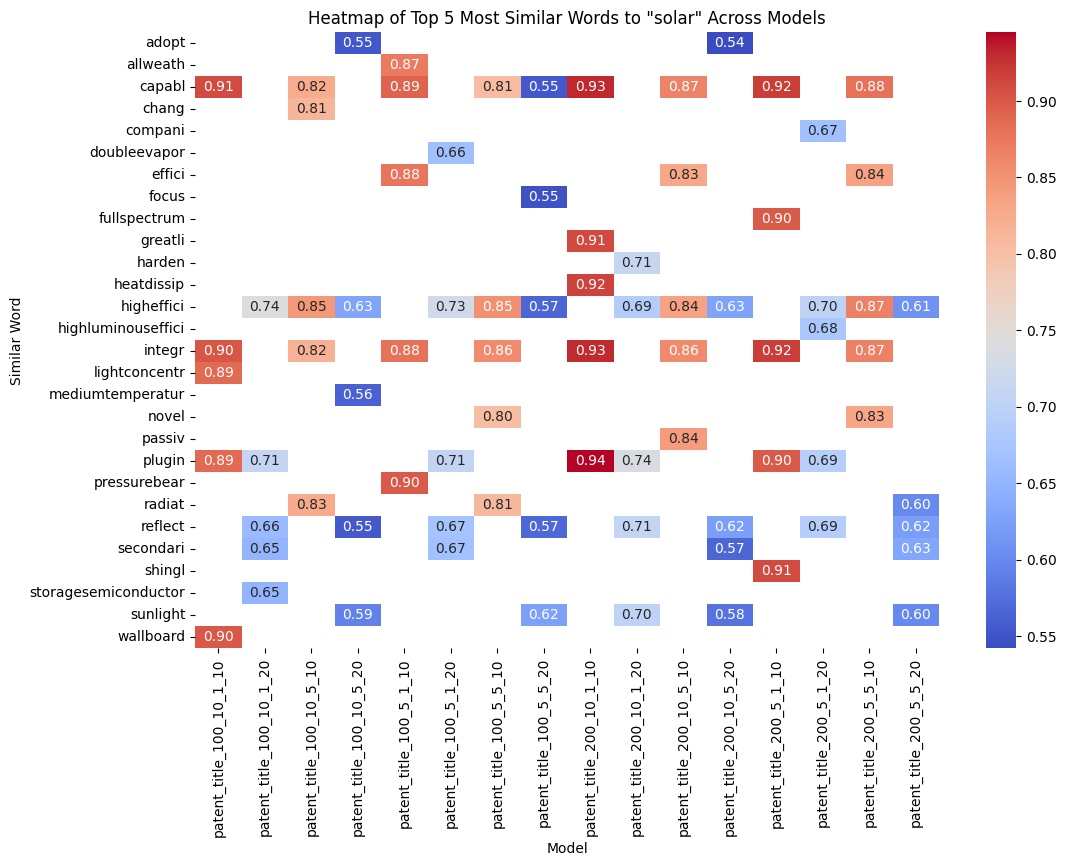

In [15]:
heatmap_data = df_similar_words.pivot_table(index='SimilarWord', columns='Model', values='Similarity', aggfunc='first')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Top 5 Most Similar Words to "solar" Across Models')
plt.xlabel('Model')
plt.ylabel('Similar Word')
plt.show()

In [16]:
from sklearn.manifold import TSNE

# Ensure all models have the same vector size
consistent_vector_size = 200  # Example size, change according to your models
filtered_models = {name: model for name, model in patent_title_models.items() if model.vector_size == consistent_vector_size}

# Collect embeddings for the words 'solar' and their top similar words from the filtered models
words = set(df_similar_words['SimilarWord'])
words.add('solar')
embeddings = []
labels = []

for word in words:
    for model_name, model in filtered_models.items():
        if word in model.wv:
            embeddings.append(model.wv[word])
            labels.append(f'{word} ({model_name})')

embeddings = np.array(embeddings)

# Use t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting t-SNE results
plt.figure(figsize=(14, 10))
for i, label in enumerate(labels):
    x, y = embeddings_2d[i, :]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), textcoords='offset points', xytext=(5, 2), ha='right')
plt.title('t-SNE visualization of Word Embeddings')
plt.show()


NameError: name 'patent_title_models' is not defined

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df
# Convert the 'Similarities' column to numeric
results_df['Similarities'] = results_df['Similarities'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)

# Recalculate the mean similarity for each model
results_df['Similarities Mean'] = results_df.groupby(['Vector Size', 'Window', 'Min Count', 'Epochs'])['Similarities'].transform('mean')

# Remove duplicate rows
results_df = results_df.drop_duplicates(subset=['Vector Size', 'Window', 'Min Count', 'Epochs'])

# Remove rows with NaN values in 'Similarities' column
results_df = results_df.dropna(subset=['Similarities'])

# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Heatmap for analogy accuracy
pivot_table_accuracy = results_df.pivot_table(values='Analogy Accuracy', index='Vector Size', columns='Window')
sns.heatmap(pivot_table_accuracy, annot=True, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Analogy Accuracy')

# Boxplot for word similarity
sns.boxplot(data=results_df, x='Vector Size', y='Similarities Mean', ax=axes[1])
axes[1].set_title('Word Similarity')

plt.tight_layout()
plt.show()

#### Word analogy

In [ ]:
# Function to evaluate word analogy
def evaluate_word_analogy(word2vec_model, analogy_pairs):
    correct_count = 0
    total_count = 0
    for analogy in analogy_pairs:
        if all(word in word2vec_model.wv for word in analogy):
            word1, word2, word3, word4 = analogy
            predicted_word = word2vec_model.wv.most_similar(positive=[word2, word3], negative=[word1])[0][0]
            if predicted_word == word4:
                correct_count += 1
            total_count += 1
    accuracy = correct_count / total_count if total_count > 0 else 0
    return accuracy